In [350]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator

import itertools

In [351]:
data = pd.read_csv('data/chips.txt',header=None, names=['X', 'Y', 'Class'])

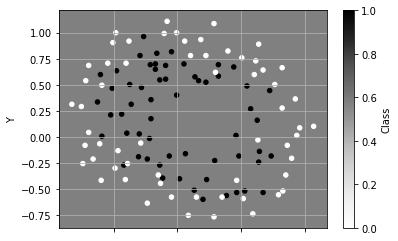

In [352]:
plot1 = data.plot(kind='scatter', x='X', y='Y', c='Class', grid=True)
plot1.set_facecolor("gray")

In [353]:
def euclidean_metric(x, y):
    return np.linalg.norm(x - y, 2)

def manhattan_metric(x, y):
    return np.linalg.norm(x - y, 1)

def weight_linear(x, k):
    return k - x

def weight_hyperbolic(x, k):
    return 1./x

def weight_id(x, k):
    return 1

def accuracy(y_true, y_pred):
    return (y_true==y_pred).sum() * 1.0 / len(y_true)

def f1_sc(y_true, y_pred):
    tp = ((y_pred == 1) * (y_pred == y_true)).sum()
    fn = ((y_pred == 0) * (y_pred != y_true)).sum()
    fp = ((y_pred == 1) * (y_pred != y_true)).sum()
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)    
    return 2 * prec * rec / (prec + rec)

class KNNClassifier(BaseEstimator):
    def __init__(self, k=1, metric=euclidean_metric, weight=weight0):
        self.k = k
        self.metric = metric
        self.w = weight

    def get_params(self, deep=False):
        return {"k": self.k,
               "metric": self.metric,
               "weight": self.w}

    def set_params(self, **params):
        self.k = params["k"]
        self.metric = params["metric"]
        self.w = params["weight"]
    
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        ys = []
        for x in X:
            order = np.apply_along_axis(lambda y: self.metric(x, y), 1, self.X)
            index = np.argsort(order)
            self.y = self.y[index]
            ws = Counter()
            for ix, v in enumerate(self.y[:self.k]):
                # linearly decreasing weights                
                ws[v] = ws.get(v, 0) + self.w(ix + 1, self.k)
            ys.append(ws.most_common(1)[0][0])
        return np.asarray(ys)
    
    def score(self, X, y, score="accuracy"):
        y_pred = self.predict(X)
        if score == "accuracy":
            return accuracy(y, y_pred)
        elif score == "f1":
            return f1_sc(y, y_pred)
        else:
            raise RuntimeError("unknown score")

In [354]:
X = data[['X', 'Y']].values
y = data['Class'].values

In [355]:
X = normalize(X)

In [356]:
X_learn, X_holdout, y_learn, y_holdout = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_test, y_train, y_test       = train_test_split(X_learn, y_learn, test_size=0.33, random_state=1)

In [357]:
print("Learn size: %d" % X_learn.shape[0])
print("  Train size: %d" % X_train.shape[0])
print("  Test size: %d" % X_test.shape[0])
print("Hold-out size: %d" % X_holdout.shape[0])

Learn size: 88
  Train size: 58
  Test size: 30
Hold-out size: 30


In [358]:
Ks = np.arange(1, 50, 1)

In [359]:
metrics = [euclidean_metric, manhattan_metric][:2]
weights = [weight_linear, weight_hyperbolic, weight_id][:3]

CPU times: user 13.3 s, sys: 8 ms, total: 13.3 s
Wall time: 13.3 s


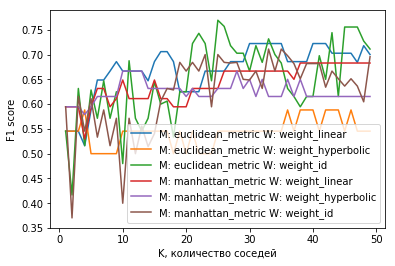

In [360]:
%%time


plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")

for metric, weight in itertools.product(metrics, weights):
    scores_1 = []
    for K in Ks:
        knn_1 = KNNClassifier(K, metric=metric, weight=weight)
        knn_1.fit(X_train, y_train)
        scores_1.append(knn_1.score(X_test, y_test, "f1"))
        
    plt.plot(Ks, scores_1, label='M: ' + metric.__name__ + ' W: ' + weight.__name__)

plt.legend(loc=0)

In [ ]:
%%time


plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")

for metric, weight in itertools.product(metrics, weights):
    scores_1 = []
    for K in Ks:        
        cv_score_1 = cross_val_score(KNNClassifier(K, metric=metric, weight=weight), X_learn, y_learn, scoring="f1", cv=5, n_jobs=-1)
        scores_1.append(np.mean(cv_score_1))        
        
    plt.plot(Ks, scores_1, label='M: ' + metric.__name__ + ' W: ' + weight.__name__)

plt.legend(loc=0)

In [366]:
K = 17
knn = KNNClassifier(K, metric=euclidean_metric, weight=weight_linear)
knn.fit(X_learn, y_learn)
print("Hold-out score (K=%d): %.2f" % (K, knn.score(X_holdout, y_holdout, "f1")))

Hold-out score (K=38): 0.35
